In [1]:
import os
from os import listdir
from os.path import isfile, join
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.color import rgb2gray
import statistics
from skimage import filters as flt
from skimage.segmentation import watershed
from skimage.filters import sobel
from scipy import ndimage as ndi


from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [2]:
# Add /scr/data folder to your system path
sys.path.append(os.pardir + '/src/data')

import segment_image as si
from segment_image import is_RGB

In [3]:
fname = '../data/interim/merged_data/not_measured/1M-A31N_10x.jpg' #9L-59_10x.jpg'
image = io.imread(fname)

In [4]:
gray = rgb2gray(image[:1700])

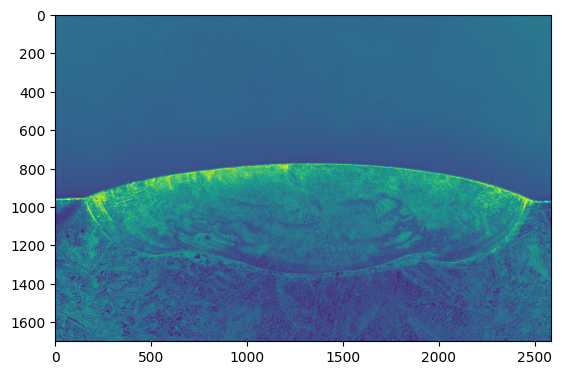

In [5]:
plt.imshow(gray)

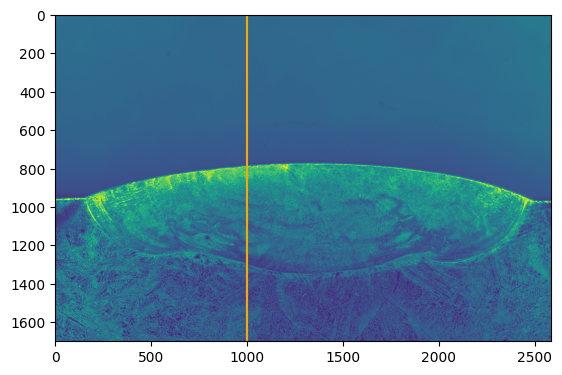

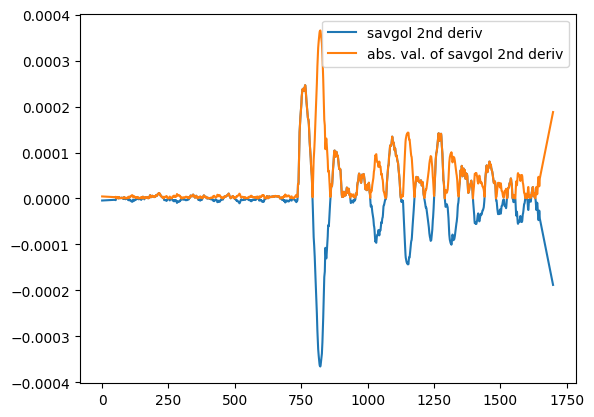

In [41]:
xline = 1000
plt.imshow(gray)
plt.axvline(xline,color='orange')
plt.show()
sav_2deriv = savgol_filter(gray[:,xline], 101, 3, deriv=2) 
sav_2deriv_abs = abs(sav_2deriv)
plt.plot(sav_2deriv, label='savgol 2nd deriv')
plt.plot(sav_2deriv_abs, label='abs. val. of savgol 2nd deriv')
plt.legend()
plt.show()

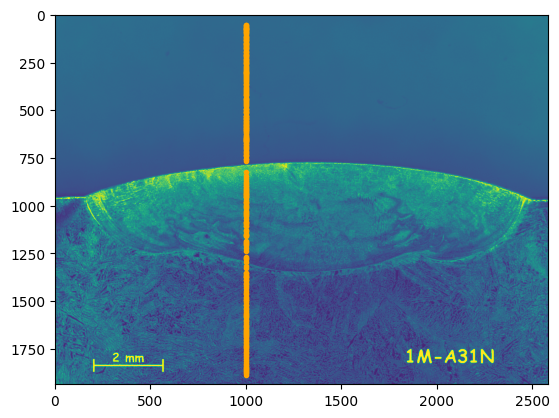

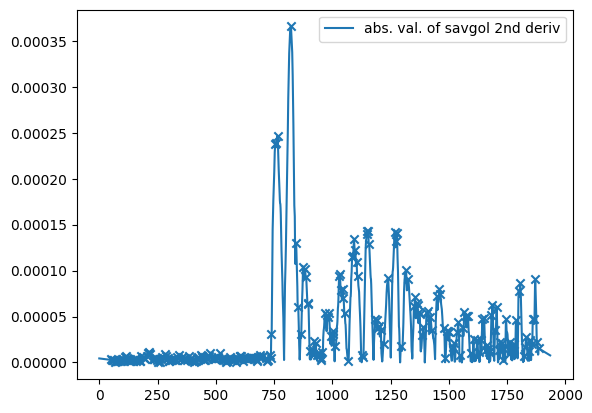

In [24]:
peaks, _ = find_peaks(sav_2deriv_abs)

plt.imshow(gray)
plt.scatter(np.array([1000]*len(peaks)), peaks, marker=".", color='orange')
plt.show()

sav_2deriv_abs_peaks = sav_2deriv_abs[peaks]
plt.plot(sav_2deriv_abs, label='abs. val. of savgol 2nd deriv')
plt.scatter(peaks, sav_2deriv_abs_peaks, marker="x")
plt.legend()
plt.show()

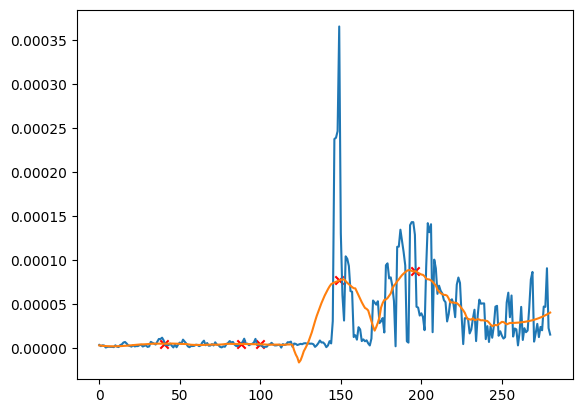

In [47]:
plt.plot(sav_2deriv_abs_peaks)
smooth_sovgal_peaks = savgol_filter(sav_2deriv_abs_peaks, 51, 3)
plt.plot(smooth_sovgal_peaks)
peaks_of_soval_peaks, _ = find_peaks(savgol_filter(smooth_sovgal_peaks, 51, 3))
smooth_sovgal_peaks_peaks = smooth_sovgal_peaks[peaks_of_soval_peaks]
plt.scatter(peaks_of_soval_peaks, smooth_sovgal_peaks_peaks, marker="x", color='red')

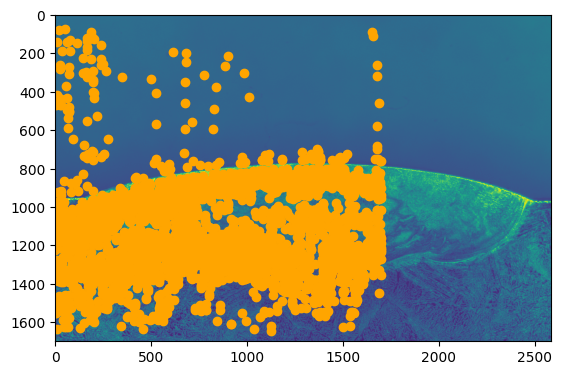

In [77]:

points = [np.array([]),np.array([])]
plt.imshow(gray)
for xline in range(gray.shape[0]):
    sav_2deriv = savgol_filter(gray[:,xline], 101, 3, deriv=2) 
    sav_2deriv_abs = abs(sav_2deriv)
    peaks, _ = find_peaks(sav_2deriv_abs)
    sav_2deriv_abs_peaks = sav_2deriv_abs[peaks]
    smooth_sav_peaks = savgol_filter(sav_2deriv_abs_peaks, 51, 3)
    peaks_smooth_sav_peaks, _ = find_peaks(smooth_sav_peaks)
    peaks_location = peaks[peaks_smooth_sav_peaks]
    df = pd.DataFrame({'height':smooth_sav_peaks[peaks_smooth_sav_peaks], 'index': peaks_location.astype('int')})
    sorted = df.sort_values('height', ascending=False)['index'].values
    peak_points_y = sorted[:3]
    peak_points_x = np.full(peak_points_y.shape, xline)
    points[0]= np.concatenate([points[0], peak_points_x])
    points[1]= np.concatenate([points[1], peak_points_y])
    plt.scatter(peak_points_x, peak_points_y, color='orange')


In [79]:
sorted[:3]

array([ 900, 1162,  760])

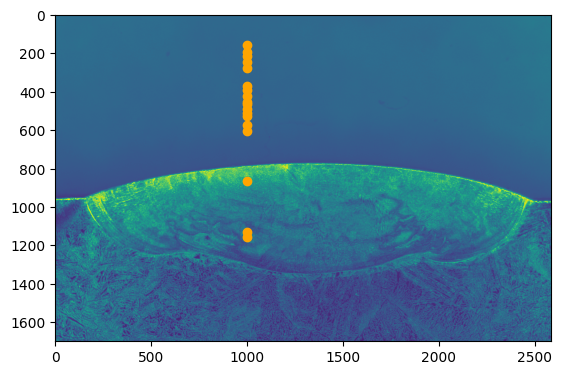

In [69]:
plt.imshow(gray)
xline = 1000
sav_2deriv = savgol_filter(gray[:,xline], 101, 3, deriv=2) 
sav_2deriv_abs = abs(sav_2deriv)
peaks, _ = find_peaks(sav_2deriv_abs)
sav_2deriv_abs_peaks = sav_2deriv_abs[peaks]
smooth_sav_peaks = savgol_filter(sav_2deriv_abs_peaks, 51, 3)
peaks_smooth_sav_peaks, _ = find_peaks(smooth_sav_peaks)
peaks_location = peaks[peaks_smooth_sav_peaks]
df = pd.DataFrame({'height':smooth_sav_peaks[peaks_smooth_sav_peaks], 'index': peaks_location.astype('int')})
sorted = df.sort_values('height', ascending=False)['index'].values
peak_points_y = sorted
peak_points_x = np.full(sorted.shape, xline)
points[0].append(list(peak_points_x))
points[1].append(list(peak_points_y))
plt.scatter(peak_points_x, peak_points_y, color='orange')

In [ ]:
df = pd.DataFrame({'height':sav_2deriv_abs_peaks, 'index': peaks})
sorted = df.sort_values('height', ascending=False)['index'].values[:3]

In [ ]:
def find_max_soval_2deriv_peak(line, axis=0):
    sav_2deriv = savgol_filter(gray[:,xline], 101, 3, deriv=2) 
    sav_2deriv_abs = abs(sav_2deriv)
    peaks, _ = find_peaks(sav_2deriv_abs)
    sav_2deriv_abs_peaks = sav_2deriv_abs[peaks]
    df = pd.DataFrame({'height':sav_2deriv_abs_peaks, 'index': peaks})
    return df.sort_values('height', ascending=False)['index'].values
    

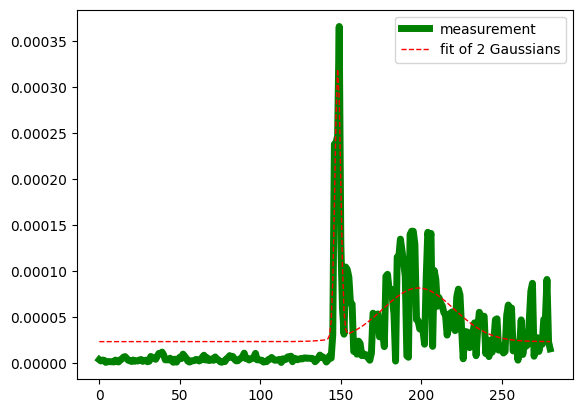

In [33]:
from scipy import optimize

def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset
def two_gaussians(x, h1, c1, w1, h2, c2, w2, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0) + offset)

errfunc2 = lambda p, x, y: (two_gaussians(x, *p) - y)**2

guess2 = [0.00035, 145, 2, 0.00015, 200, 5, 0]

x = np.array(range(len(sav_2deriv_abs_peaks)))
optim2, success = optimize.leastsq(errfunc2, guess2[:],
                                   args=(x, sav_2deriv_abs_peaks))


plt.plot( sav_2deriv_abs_peaks, lw=5, c='g', label='measurement')
plt.plot(x, two_gaussians(x, *optim2),
    lw=1, c='r', ls='--', label='fit of 2 Gaussians')
plt.legend(loc='best')

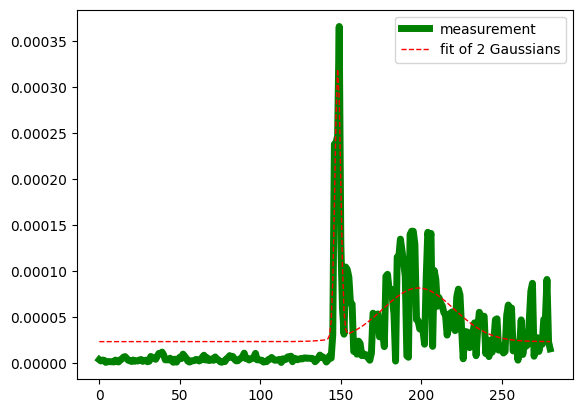

In [ ]:
from scipy import optimize

def gaussian(x, height, center, width, offset):
    return height*np.exp(-(x - center)**2/(2*width**2)) + offset
def two_gaussians(x, h1, c1, w1, h2, c2, w2, offset):
    return (gaussian(x, h1, c1, w1, offset=0) +
        gaussian(x, h2, c2, w2, offset=0) + offset)

errfunc2 = lambda p, x, y: (two_gaussians(x, *p) - y)**2

guess2 = [0.00035, 145, 2, 0.00015, 200, 5, 0]

x = np.array(range(len(sav_2deriv_abs_peaks)))
optim2, success = optimize.leastsq(errfunc2, guess2[:],
                                   args=(x, sav_2deriv_abs_peaks))


plt.plot( sav_2deriv_abs_peaks, lw=5, c='g', label='measurement')
plt.plot(x, two_gaussians(x, *optim2),
    lw=1, c='r', ls='--', label='fit of 2 Gaussians')
plt.legend(loc='best')

# Maximum peak in absolut value of soval filter's 2nd derivative

This method goes as follows:
1. Identify the reference line as the global maximum of the soval filter's 2nd derivative in the 50th pixal.
2. search for the maximum before and after this reference line. assuming that it will correspond to the weld edges.

In [42]:
def find_max_soval_2deriv_peak(line, axis=0):
    sav_2deriv = savgol_filter(gray[:,xline], 101, 3, deriv=2) 
    sav_2deriv_abs = abs(sav_2deriv)
    peaks, _ = find_peaks(sav_2deriv_abs)
    sav_2deriv_abs_peaks = sav_2deriv_abs[peaks]
    max_peak = sav_2deriv_abs_peaks.max()
    return sav_2deriv_abs_peaks[np.where(sav_2deriv_abs_peaks == max_peak)]
    

In [43]:
reference_line = find_max_soval_2deriv_peak(50)